In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs 

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

### dask 
from dask.diagnostics import ProgressBar

In [3]:
import dask

### paths 

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### load local libraries 

In [5]:
sys.path.append('../../') 

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, verification

In [7]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [8]:
domain = domains.domains['Water_Watch']

### import libraries for validation

In [9]:
import climpred
from climpred import HindcastEnsemble
import xskillscore as xs

### parameters for papermill 

In [10]:
verif_dset = 'ERA'
quantile = 'tercile'
varname = 'TPRATE'
period = 'monthly'
step = 1
composites = 'all'

In [11]:
opath_mme_probabilities = CWD.parents[1].joinpath(f"outputs/C3S_MME_{quantile}_probabilities")

In [12]:
lfiles = list(opath_mme_probabilities.glob("*"))

In [13]:
lfiles

[PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_tercile_probabilities/C3S_MME_seasonal_tercile_probabilities.zarr'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_tercile_probabilities/C3S_MME_monthly_tercile_probabilities.zarr')]

In [14]:
dset_mme = xr.open_zarr(opath_mme_probabilities.joinpath(f"C3S_MME_{period}_{quantile}_probabilities.zarr"))

In [15]:
dset_mme

,Array,Chunk
Bytes,2.52 GiB,1.76 MiB
Shape,"(8, 288, 3, 5, 81, 121)","(8, 288, 1, 1, 10, 10)"
Count,1756 Tasks,1755 Chunks
Type,float64,numpy.ndarray


In [16]:
dset_mme.GCM

<xarray.DataArray 'GCM' (GCM: 8)>
array(['CMCC', 'DWD', 'ECMWF', 'JMA', 'METEO_FRANCE', 'MME', 'NCEP', 'UKMO'],
      dtype='<U12')
Coordinates:
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'

### take the leadtime in the GCM

In [17]:
dset_mme = dset_mme.sel(step=step)

In [18]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 1
    time     datetime64[ns] 1993-01-01

### get the most likely tercile 

### most likely tercile 

In [19]:
dset_mme = dset_mme.idxmax(dim=quantile)

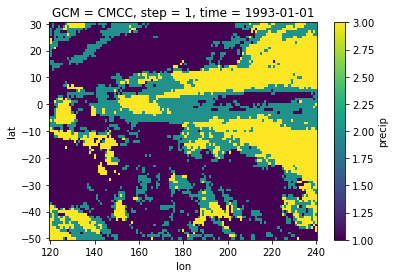

In [20]:
dset_mme['precip'][0,0,:,:].plot()

### here loads the indices 

In [21]:
def load_climate_indices(indice='NINO3.4', seasonal=True): 
    
    if indices == 'NINO3.4': 
    
        nino = verification.get_CPC_NINO()

        nino = nino.rename({'NINO3.4':'NINO34'}, axis=1)
        
        nino = (nino - nino.loc['1981':'2010',:].mean() )/ nino.loc['1981':'2010',:].std()
        
        if seasonal: 
        
            nino = nino.rolling(window=3, min_periods=3).mean()
        
        return nino
        
    if indices == 'EMI': 
        
        emi = pd.read_csv('./climate_indices/EMI.csv', index_col=0, parse_dates=True)

        if seasonal:
        
            emi = emi[['EMI_seasonal_std']]
        
        else: 
            
            emi = emi[['EMIstd']]

        return emi
    

### change the time axis so that it is shifted by the correct amount of `step` (lead months) to align with the observations 

In [22]:
dset_mme['time'] = dset_mme.indexes['time'] + pd.offsets.MonthBegin(step)

In [23]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-02-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 1
    time     datetime64[ns] 1993-02-01

### Now reads in the verification dataset 

In [24]:
opath_verif_categories = CWD.parents[1].joinpath(f"outputs/{verif_dset}_{quantile}_categories")

In [25]:
verif_quantile_categories = xr.open_zarr(opath_verif_categories.joinpath(f"{verif_dset}_{quantile}_{period}_categories.zarr"))

### merge the datasets 

In [26]:
dset_mme, verif_quantile_categories = xr.align(dset_mme, verif_quantile_categories)

In [27]:
dset_merge = dset_mme.rename_vars({'precip':'gcm'}).merge(verif_quantile_categories.rename_vars({'precip':'verif'}))

In [28]:
dset_merge

<xarray.Dataset>
Dimensions:  (lat: 61, lon: 116, time: 287, GCM: 8)
Coordinates:
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float64 125.0 126.0 127.0 128.0 ... 237.0 238.0 239.0 240.0
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
    step     int64 1
    month    (time) int64 dask.array<chunksize=(287,), meta=np.ndarray>
Data variables:
    gcm      (GCM, time, lat, lon) float64 dask.array<chunksize=(1, 287, 5, 5), meta=np.ndarray>
    verif    (time, lat, lon) int64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

### rechunk 

In [29]:
dset_merge = dset_merge.chunk({'time':-1, 'lat':10, 'lon':10},)

In [30]:
dset_merge.nbytes / 1e9

0.146224864

In [31]:
with ProgressBar(): 
    dset_merge = dset_merge.compute()

[########################################] | 100% Completed | 20.3s


In [32]:
dset_merge

<xarray.Dataset>
Dimensions:  (lat: 61, lon: 116, time: 287, GCM: 8)
Coordinates:
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float64 125.0 126.0 127.0 128.0 ... 237.0 238.0 239.0 240.0
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
    step     int64 1
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    gcm      (GCM, time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.0 3.0 3.0 3.0
    verif    (time, lat, lon) int64 3 2 2 3 3 3 2 2 1 1 ... 3 3 3 2 2 3 3 3 3 3

In [33]:
dset = dset_merge.sel(GCM='MME')

In [34]:
fnegatives =  verification.false_negatives(dset)

In [35]:
fpositives = verification.false_positives(dset)

In [36]:
tpositives = verification.true_positives(dset)

In [37]:
tnegatives = verification.true_negatives(dset)

In [38]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [39]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

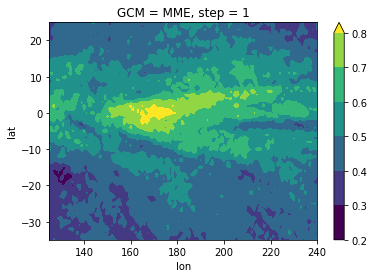

In [40]:
precision.plot.contourf(levels=np.arange(0.2, 0.9,  0.1))

In [41]:
class_dict = {}
class_dict[1] = ['lower', '< 1st tercile']
class_dict[2] = ['middle', 'between 1st and 2nd tercile']
class_dict[3] = ['upper', '> 1st tercile']

In [42]:
class_value = 1

In [44]:
fnegatives = verification.false_negatives(dset, class_value=class_value)

In [45]:
fpositives = verification.false_positives(dset, class_value=class_value)

In [46]:
tpositives = verification.true_positives(dset, class_value=class_value)

In [47]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [48]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

In [49]:
cbar_kwargs = dict(shrink=0.8, orientation='vertical', drawedges=True, pad=0.01)

In [50]:
F1_Score = 2*(recall * precision) / (recall + precision)

In [51]:
import palettable

In [52]:
cmap = palettable.scientific.sequential.Oslo_20_r.mpl_colormap

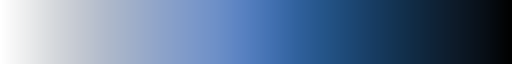

In [53]:
cmap

In [54]:
if period == 'seasonal': 
    period_label = 'season'
    lead = step - 2 
elif period == 'monthly': 
    period_label = 'month'
    lead = step

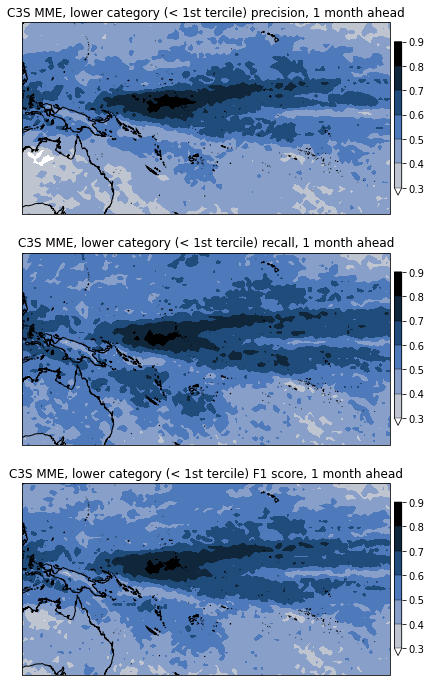

In [56]:
f, axes = plt.subplots(nrows=3, figsize=(8,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

axes = axes.flatten()

ax = axes[0]

precision.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) precision, {lead} {period_label} ahead")

ax = axes[1]

recall.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) recall, {lead} {period_label} ahead")

ax = axes[2]

F1_Score.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) F1 score, {lead} {period_label} ahead")

f.savefig(f'./{quantile}_{class_dict[class_value][0]}_precision_recall_F1score_{lead}_{period_label}_ahead.png', dpi=200, bbox_inches='tight', facecolor='w')

In [57]:
acc = dset['gcm'] == dset['verif']

In [58]:
acc = acc.sum('time') / len(acc.time)

In [59]:
cbar_kwargs.update(shrink=0.5)

In [60]:
cbar_kwargs

{'shrink': 0.5, 'orientation': 'vertical', 'drawedges': True, 'pad': 0.01}

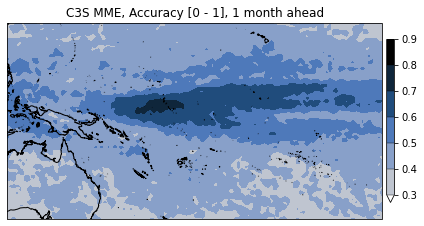

In [61]:
f, ax = plt.subplots(figsize=(8,6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

acc.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, Accuracy [0 - 1], {lead} {period_label} ahead")

f.savefig(f'./{quantile}_{class_dict[class_value][0]}_accuracy_{lead}_{period_label}_ahead.png', dpi=200, bbox_inches='tight', facecolor='w')

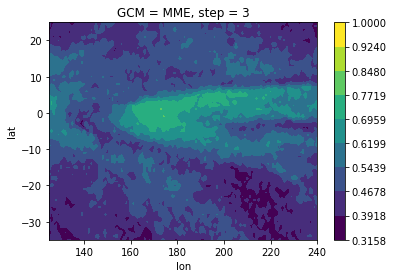

In [61]:
acc.plot.contourf(levels=10, vmax=1)

In [62]:
accuracy = (tpositives+tnegatives)/(tpositives+fpositives+fnegatives+tnegatives) 

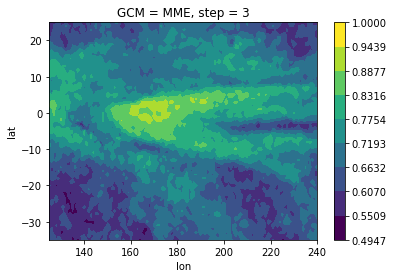

In [64]:
accuracy.plot.contourf(levels=10, vmax=1)

## load the climate indices 

In [72]:
nino = verification.get_CPC_NINO()

nino = nino.rename({'NINO3.4':'NINO34'}, axis=1)

emi = pd.read_csv('./climate_indices/EMI.csv', index_col=0, parse_dates=True)

emi = emi[['EMI_seasonal_std']]

nino = nino.rolling(window=3, min_periods=3).mean()

nino = (nino - nino.loc['1981':'2010',:].mean() )/ nino.loc['1981':'2010',:].std()

ninos = nino.query('NINO34 >= 1')

ninas = nino.query('NINO34 <= -1')

### ok so for selecting the initial months corresponding to ENSO phases, we first need to re-shift the MME dataset in time 

In [73]:
dset_mme

,Array,Chunk
Bytes,123.09 MiB,222.66 kiB
Shape,"(8, 285, 61, 116)","(1, 285, 10, 10)"
Count,10437 Tasks,728 Chunks
Type,float64,numpy.ndarray


In [74]:
dset.time[0]

<xarray.DataArray 'time' ()>
array('1993-04-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1993-04-01
    GCM      <U12 'MME'
    step     int64 3
    month    int64 4

In [75]:
dset_mme['time'] = dset_mme.indexes['time'] - pd.offsets.MonthBegin(step)

In [77]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1993-01-01
    step     int64 3

### then we select the ninos months

In [80]:
ninos.index.name = 'time'

<xarray.Dataset>
Dimensions:  (time: 69)
Coordinates:
  * time     (time) datetime64[ns] 1982-08-01 1982-09-01 ... 2016-05-01
Data variables:
    NINO34   (time) float64 1.023 1.13 1.515 1.867 ... 2.812 2.436 1.863 1.083

In [83]:
dset_mme_enso, ninos = xr.align(dset_mme, ninos.to_xarray())

### now shift back 

In [87]:
dset_mme_enso['time'] = dset_mme_enso.indexes['time'] + pd.offsets.MonthBegin(step)

In [88]:
dset_mme_enso

,Array,Chunk
Bytes,16.84 MiB,30.47 kiB
Shape,"(8, 39, 61, 116)","(1, 39, 10, 10)"
Count,11165 Tasks,728 Chunks
Type,float64,numpy.ndarray


In [89]:
dset_mme_enso, verif_quantile_categories_enso = xr.align(dset_mme_enso, verif_quantile_categories)

In [90]:
dset_merge_enso = dset_mme_enso.rename_vars({'precip':'gcm'}).merge(verif_quantile_categories_enso.rename_vars({'precip':'verif'}))

In [91]:
dset_merge_enso

<xarray.Dataset>
Dimensions:  (time: 39, lat: 61, lon: 116, GCM: 8)
Coordinates:
  * time     (time) datetime64[ns] 1995-03-01 1995-04-01 ... 2016-08-01
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float64 125.0 126.0 127.0 128.0 ... 237.0 238.0 239.0 240.0
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
    step     int64 3
    month    (time) int64 dask.array<chunksize=(39,), meta=np.ndarray>
Data variables:
    gcm      (GCM, time, lat, lon) float64 dask.array<chunksize=(1, 39, 5, 5), meta=np.ndarray>
    verif    (time, lat, lon) int64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

In [92]:
dset_merge_enso = dset_merge_enso.sel(GCM='MME')

In [94]:
dset_merge_enso

<xarray.Dataset>
Dimensions:  (time: 39, lat: 61, lon: 116)
Coordinates:
  * time     (time) datetime64[ns] 1995-03-01 1995-04-01 ... 2016-08-01
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float64 125.0 126.0 127.0 128.0 ... 237.0 238.0 239.0 240.0
    GCM      <U12 'MME'
    step     int64 3
    month    (time) int64 dask.array<chunksize=(39,), meta=np.ndarray>
Data variables:
    gcm      (time, lat, lon) float64 dask.array<chunksize=(39, 5, 5), meta=np.ndarray>
    verif    (time, lat, lon) int64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

In [95]:
dset_merge_enso = dset_merge_enso.chunk({'time':-1, 'lat':10, 'lon':10},)

In [96]:
dset_merge_enso.nbytes / 1e9

0.00441752

In [97]:
with ProgressBar(): 
    dset_merge_enso = dset_merge_enso.compute()

[########################################] | 100% Completed |  3.8s


In [99]:
fnegatives = false_negatives(dset_merge_enso)

In [100]:
fpositives = false_positives(dset_merge_enso)

In [101]:
tpositives = true_positives(dset_merge_enso)

In [102]:
tnegatives = true_negatives(dset_merge_enso)

In [103]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [104]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

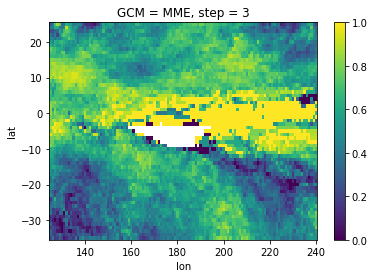

In [111]:
precision.plot()

In [ ]:
verif_quantile_categories_enso